In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 13 19:18:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#The libraries/modules used. Please ensure that they follow version dependancies

import tensorflow_datasets as data
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D, Add, Input, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from io import StringIO
import re
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
import time
import matplotlib.pyplot as plt
# example of loading the cifar10 dataset
from matplotlib import pyplot
from keras.datasets import cifar10

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


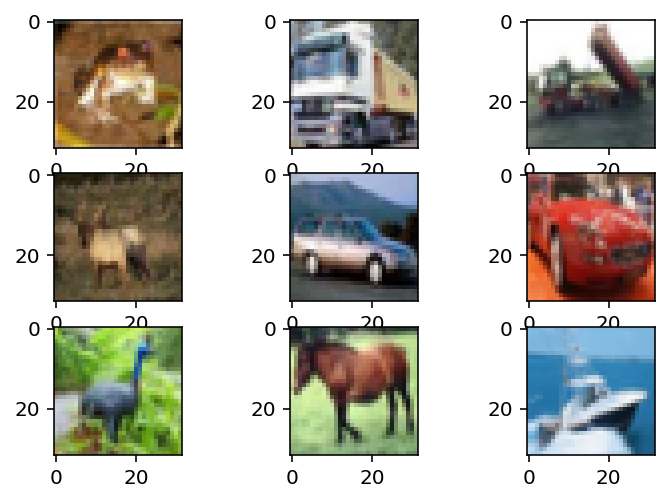

In [ ]:
# load dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_x.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_x.shape, test_y.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(train_x[i])
# show the figure
pyplot.show()

In [ ]:
#Class for generating image data based on pixel information
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, cutout_mask_size = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_mask_size = cutout_mask_size
        
    def cutout(self, x, y):
        return np.array(list(map(self._cutout, x))), y
    
    def _cutout(self, image_origin):
        image = np.copy(image_origin)
        mask_value = image.mean()

        h, w, _ = image.shape
        top = np.random.randint(0 - self.cutout_mask_size // 2, h - self.cutout_mask_size)
        left = np.random.randint(0 - self.cutout_mask_size // 2, w - self.cutout_mask_size)
        bottom = top + self.cutout_mask_size
        right = left + self.cutout_mask_size

        if top < 0:
            top = 0
        if left < 0:
            left = 0

        image[top:bottom, left:right, :].fill(mask_value)
        return image
    
    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)

        while True:
            batch_x, batch_y = next(batches)
            
            if self.cutout_mask_size > 0:
                result = self.cutout(batch_x, batch_y)
                batch_x, batch_y = result                        
                
            yield (batch_x, batch_y)     

datagen_parameters = {"horizontal_flip": True, "width_shift_range": 0.1, "height_shift_range": 0.1, "cutout_mask_size": 16}
datagen = CustomImageDataGenerator(**datagen_parameters)
datagen_for_test = ImageDataGenerator()

datagen.fit(train_x)
datagen_for_test.fit(test_x)

In [ ]:

n = 9 # 56 layers
channels = [16, 32, 64]

inputs = Input(shape=(32, 32, 3))
x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation(tf.nn.relu)(x)

for c in channels:
    for i in range(n):
        subsampling = i == 0 and c > 16
        strides = (2, 2) if subsampling else (1, 1)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation(tf.nn.relu)(y)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)        
        if subsampling:
            x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        x = Add()([x, y])
        x = Activation(tf.nn.relu)(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
outputs = Dense(10, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

model = Model(inputs=inputs, outputs=outputs)
model.type = "resnet" + str(6 * n + 2)

In [ ]:
with StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + "\n"))
    summary = buf.getvalue()
print(summary)
re1 = re.match(r"(.|\s)*Total params: ", summary)
re2 = re.match(r"(.|\s)*Total params: [\d|,]+", summary)
total_params = summary[re1.end():re2.end()]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v2_55 (Batc (None, 32, 32, 16)   64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 32, 32, 16)   0           batch_normalization_v2_55[0][0]  
____________________________________________________________________________________________

In [ ]:
lr = 0.01
optimizer = Adam(learning_rate=lr, momentum=0.9)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
class LearningController(Callback):
    def __init__(self, num_epoch=0, learn_minute=0):
        self.num_epoch = num_epoch
        self.learn_second = learn_minute * 60
        if self.learn_second > 0:
            print("Leraning rate is controled by time.")
        elif self.num_epoch > 0:
            print("Leraning rate is controled by epoch.")
        
    def on_train_begin(self, logs=None):
        if self.learn_second > 0:
            self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        if self.learn_second > 0:
            current_time = time.time()
            if current_time - self.start_time > self.learn_second:
                self.model.stop_training = True
                print("Time is up.")
                return

            if current_time - self.start_time > self.learn_second / 2:
                self.model.optimizer.lr = lr * 0.1            
            if current_time - self.start_time > self.learn_second * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                
        elif self.num_epoch > 0:
            if epoch > self.num_epoch / 2:
                self.model.optimizer.lr = lr * 0.1            
            if epoch > self.num_epoch * 3 / 4:
                self.model.optimizer.lr = lr * 0.01
                    
        print('lr:%.2e' % self.model.optimizer.lr.value())

In [ ]:
num_epoch = 182
learn_minute = 120

In [ ]:
checkpoint = ModelCheckpoint(filepath = "ResNet-for-CIFAR-10-with-Keras.h5", monitor="val_loss", verbose=0, save_best_only=True)
learning_controller = LearningController(num_epoch)
callbacks = [checkpoint, learning_controller]

In [ ]:
batch_size = 128
data, info = data.load('cifar10', as_supervised = True, batch_size = -1)
number_train = info.splits["train"].num_examples
number_test = info.splits["test"].num_examples

In [ ]:
model.param("Model type", model.type)
model.param("Total params", total_params)
model.param("Optimizer", optimizer)
model.param("Leraning rate", lr)
model.param("Datagen", datagen_parameters)
model.param("Batch size", batch_size)
model.param("Number of epoch", num_epoch)
model.param("Learn minute", learn_minute)

120

In [ ]:
history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size), 
                    epochs=num_epoch, 
                    steps_per_epoch=number_train//batch_size, 
                    validation_data=datagen_for_test.flow(test_x, test_y, batch_size=batch_size), 
                    validation_steps=number_test//batch_size,
                    verbose=0,                    
                    callbacks=callbacks)

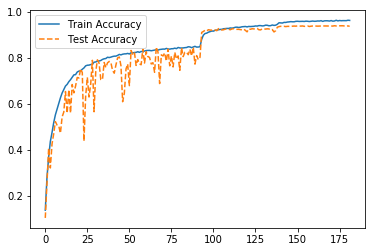

In [ ]:

plt.plot(history.history["accuracy"], label = 'Train Accuracy')
plt.plot(history.history["val_accuracy"], linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 3s 323us/sample - loss: 0.3844 - accuracy: 0.9358


[0.3843775578975677, 0.9358]